In [1]:
import pandas

path = "polarity_dataframe.csv"

df = pandas.read_csv(path)
print(df.head())

review = df.review.tolist()
y = df.pos.tolist()


   Unnamed: 0                                             review  pos
0           0  when the haunting arrived in theaters , all i ...    0
1           1  movies can do the two big es very well : educa...    0
2           2   " america's sweethearts " has an intriguing p...    0
3           3  remember back in the mid 1990s when crime and ...    0
4           4  when i originally saw the trailer for " analyz...    0


Many unneeded words: "stop words" remains, inintelligible words ("______", "0009f", ...), |words| <= 2,3.

In [2]:
def is_only_underscore(word):
    return len(word.replace("_", "")) == 0

def is_only_dash(word):
    return len(word.replace("-", "")) == 0

from functools import reduce

def contains_number(word):
    return any(i.isdigit() for i in word)

def small_length(word):
    return len(word) == 1 and (word!='i' or word!='a')

def remove_word(word):
    return is_only_underscore(word) or contains_number(word) or small_length(word) 

In [3]:
new_review=[]
for sentence in review[:1]:
    new_sentence=[]
    for word in (sentence.strip()).split():
        if not remove_word(word):
            new_sentence.append(word)

    new_review.append(' '.join(new_sentence))
    #print(sentence)


print("New Sentences: \n", new_review[0])


New Sentences: 
 when the haunting arrived in theaters all kept hearing about was the overdone special effects and the fact that very often the unseen bumps in the night in horror film are far scarier than those that you can put face to courtesy of special effects while agree that this remake of the haunting goes bit overboard in the visual effects department don't think that they are completely to blame for this movie's failure it appears that some people have failed to take into account that the original haunting had the unseen terrors and it was about as scary as dust bunny so special effects or not if the story isn't the least bit scary you aren't going to end up with very frightening movie the thing that interested me most about this movie was the caretaker of this building played by bruce dern dern is always great and even though he may have had only about minutes of screen time he was still the most interesting element of the movie as sat through the seemingly endless albeit fai

In [4]:
# Split the dataframe to train and Test sets

from sklearn.model_selection import train_test_split
review_train, review_test, y_train, y_test = train_test_split(review, y, random_state=1)

print('Data list length : \n Train : ',len(review_train),'Test : ',len(review_test))

Data list length : 
 Train :  1500 Test :  500


In [5]:
from sklearn.feature_extraction.text import CountVectorizer
# import and instantiate CountVectorizer (with the default parameters)
vect = CountVectorizer() 

# learn training data vocabulary, then use it to create a document-term matrix
vect.fit(review_train)
review_train_dtm = vect.transform(review_train)
# or equivalently: combine fit and transform into a single step
#X_train_dtm = vect.fit_transform(X_train)

print("Total number of different words: ", len(vect.get_feature_names()))


Total number of different words:  35321


In [6]:
# transform testing data (using fitted vocabulary) into a document-term matrix
review_test_dtm = vect.transform(review_test)


## Building and evaluating a model

We will use [multinomial Naive Bayes](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html):

> The multinomial Naive Bayes classifier is suitable for classification with **discrete features** (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

In [7]:
# import and instantiate a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

# train the model using X_train_dtm (timing it with an IPython "magic command")
%time nb.fit(review_train_dtm, y_train)

Wall time: 17.1 ms


MultinomialNB()

In [8]:
# make class predictions for test sentences (using X_test_dtm representation)
y_pred_class = nb.predict(review_test_dtm)

# tranformation into a boolean array
#print(y_pred_class==1)

# some sms predicted as spam
#print(review_test[y_pred_class==1].head())
pairs={ y_pred_class[i] : review_test[i] for i in range(len(review_test))}

#print(pairs[0])

In [9]:
# compute accuracy of class predictions
from sklearn import metrics
print('Accuracy :')
print(metrics.accuracy_score(y_test, y_pred_class))

# compute the confusion matrix
print('Confusion matrix :')
metrics.confusion_matrix(y_test, y_pred_class)

Accuracy :
0.79
Confusion matrix :


array([[207,  48],
       [ 57, 188]], dtype=int64)

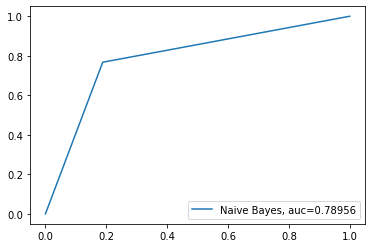

In [10]:
#Graphic representation of the ROC curve

import numpy as np
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_class, pos_label=1)

# calculate AUC (area uder the ROC curve)
auc = metrics.roc_auc_score(y_test, y_pred_class)
auc

import matplotlib.pyplot as plt
plt.plot(fpr,tpr,label=f"Naive Bayes, auc={auc:.5}")
plt.legend(loc=4)
plt.show()



## Tuning the vectorizer (discussion)

So far, we have been using the default parameters of [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html):

Let's try to remove English stop words using the implement method then change the length of words taken in account 

In [16]:
# Crete the new vect :
# remove English stop words
# include 1-grams and 2-grams
# ignore terms that appear in more than 50% of the comments
new_vect = CountVectorizer(stop_words='english',ngram_range=(1, 2),max_df=0.5)

new_review_train_dtm = new_vect.fit_transform(review_train)

# transform testing data (using fitted vocabulary) into a document-term matrix
new_review_test_dtm = new_vect.transform(review_test)

print("New total number of different features: ", len(new_vect.get_feature_names()))

# show new parameters :
new_vect.get_params()

New total number of different features:  415234


{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 0.5,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 2),
 'preprocessor': None,
 'stop_words': 'english',
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

In [12]:
# Train the naive Bayes based on the new features
new_nb = MultinomialNB()
new_nb.fit(new_review_train_dtm, y_train)

MultinomialNB()

New accuracy :
0.796


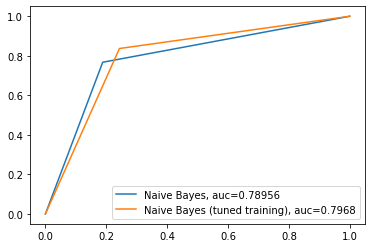

In [13]:
# Test the tuned training
y_pred_new = new_nb.predict(new_review_test_dtm)
y_pred_new

print('New accuracy :')
print(metrics.accuracy_score(y_test, y_pred_new))

# Graphic comparaison :
new_fpr, new_tpr, new_thresholds = roc_curve(y_test, y_pred_new, pos_label=1)

# calculate AUC (area uder the ROC curve)
new_auc = metrics.roc_auc_score(y_test, y_pred_new)

plt.plot(fpr,tpr,label=f"Naive Bayes, auc={auc:.5}")
plt.plot(new_fpr,new_tpr,label=f"Naive Bayes (tuned training), auc={new_auc:.5}")
plt.legend(loc=4)
plt.show()